# Binary Classification Deep Learning Model for MiniBooNE Particle Identification Using Keras
### David Lowe
### November 26, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The MiniBooNE Particle Identification dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: This dataset is taken from the MiniBooNE experiment and is used to distinguish electron neutrinos (signal) from muon neutrinos (background). The data file is set up as follows. In the first line is the number of signal events followed by the number of background events. The records with the signal events come first, followed by the background events. Each line, after the first line, has the 50 particle ID variables for one event.

ANALYSIS: The baseline performance of the model achieved an average accuracy score of 93.62%. After tuning the hyperparameters, the best model processed the training dataset with an accuracy of 93.70%. Furthermore, the final model processed the test dataset with an accuracy of 93.94%, which was consistent with the accuracy result from the training dataset.

CONCLUSION: For this dataset, the model built using Keras and TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: MiniBooNE Particle Identification Dataset

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/MiniBooNE+particle+identification

Any deep-learning modeling project genrally can be broken down into about six major tasks:
0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
import keras as K
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

Using TensorFlow backend.


In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
verbose = True
tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_kernel_init = K.initializers.RandomNormal(seed=seedNum)
default_loss = 'binary_crossentropy'
default_optimizer = 'adam'
default_epochs = 500
default_batches = 32
default_metrics = ['accuracy']

Num GPUs Available:  0


In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [7]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [8]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00199/MiniBooNE_PID.txt'

signal_rec = 36499
widthVector = [14] * 50
colNames = ["particle" + str(i).zfill(2) for i in range(1,51)]
Xy_original = pd.read_fwf(dataset_path, widths=widthVector, header=None, names=colNames, skiprows=1, index_col=False, na_values=[-999])
Xy_original['targetVar'] = 0
Xy_original.iloc[:signal_rec, len(Xy_original.columns)-1] = 1

# Take a peek at the dataframe after import
Xy_original.head(10)

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,...,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50,targetVar
0,2.59413,0.468803,20.69160,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,...,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996,1
1,3.86388,0.645781,18.13750,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,...,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621,1
2,3.38584,1.197140,36.08070,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,...,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901,1
3,4.28524,0.510155,674.20100,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,...,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990,1
4,5.93662,0.832993,59.87960,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,...,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893,1
5,4.41251,2.157210,66.78530,0.335389,0.004274,0.133690,0.696868,0.753386,3.45575,0.150908,...,-18.5469,0.638310,5.97304,0.000000,0.156063,0.458479,3.500280,3.616290,0.189857,1
6,3.41292,0.834852,45.59630,0.253942,0.009479,0.290691,1.273870,0.891223,3.42853,0.227561,...,-11.3654,0.060045,4.85395,0.000000,0.102631,-0.036952,0.862529,0.671407,0.254095,1
7,2.93345,0.243213,9.73308,0.243312,0.018536,0.516637,1.188590,0.904027,3.38835,0.240489,...,-25.0214,0.015407,4.66803,0.001854,0.108072,-0.149434,0.451253,-0.182719,0.229547,1
8,4.10757,0.682600,83.69250,0.263911,0.005181,0.168942,1.403150,0.889605,3.26032,0.187648,...,-11.0120,0.566295,4.06860,0.000000,0.181448,0.265645,1.500240,0.457965,0.207168,1
9,3.82959,0.507140,29.43650,0.240391,0.010465,0.284973,1.305070,0.898304,3.05597,0.197686,...,16.6402,0.567033,1.72581,0.000000,0.195321,0.106837,2.030230,0.188336,0.296247,1


In [9]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130064 entries, 0 to 130063
Data columns (total 51 columns):
particle01    129596 non-null float64
particle02    129596 non-null float64
particle03    129596 non-null float64
particle04    129596 non-null float64
particle05    129596 non-null float64
particle06    129596 non-null float64
particle07    129596 non-null float64
particle08    129596 non-null float64
particle09    129596 non-null float64
particle10    129596 non-null float64
particle11    129596 non-null float64
particle12    129596 non-null float64
particle13    129596 non-null float64
particle14    129596 non-null float64
particle15    129596 non-null float64
particle16    129596 non-null float64
particle17    129596 non-null float64
particle18    129596 non-null float64
particle19    129596 non-null float64
particle20    129596 non-null float64
particle21    129596 non-null float64
particle22    129596 non-null float64
particle23    129596 non-null float64
particle24    1

In [10]:
Xy_original.describe()

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,...,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50,targetVar
count,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,...,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,130064.000000
mean,4.863931,1.492450,127.849703,0.283131,0.009311,0.160797,0.970221,0.823904,3.451369,0.173899,...,-21.709448,0.733346,6.009403,0.009058,0.178782,-0.159174,2.859957,1.613380,0.230708,0.280623
std,1.161277,0.860538,184.363509,0.059554,0.012493,0.122911,0.342953,0.070467,0.258654,0.043707,...,33.858218,1.224392,4.562213,0.029533,0.080407,0.977600,1.917000,1.960976,0.052818,0.449306
min,0.000000,0.059691,0.012381,0.104697,-0.156118,0.000000,0.000000,0.033510,2.375270,0.033432,...,-387.617000,-1.686500,0.249186,0.000000,0.000000,-32.109800,-13.492200,-15.997800,0.000000,0.000000
25%,4.021948,0.882372,49.978850,0.241901,0.001245,0.086348,0.717548,0.783985,3.286500,0.143172,...,-39.847675,-0.022607,3.428092,0.000000,0.122498,-0.336228,1.430775,0.281640,0.197748,0.000000
50%,4.793385,1.385640,106.423000,0.272313,0.005013,0.141468,0.924166,0.834244,3.427935,0.170756,...,-21.456250,0.462485,4.772420,0.000000,0.168887,0.043698,2.372290,1.130715,0.231553,0.000000
75%,5.632045,1.950260,138.994000,0.315312,0.013183,0.213450,1.181228,0.874354,3.586220,0.200121,...,-3.254285,1.153780,6.869710,0.002000,0.224994,0.295472,3.784865,2.286112,0.263353,1.000000
max,17.057300,8.802820,4747.670000,0.736804,0.179012,0.703859,6.241080,0.989713,7.170170,0.524888,...,161.298000,43.651200,85.823100,0.446914,0.605667,1.932890,21.768200,25.423300,0.625484,1.000000


In [11]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

particle01    468
particle02    468
particle03    468
particle04    468
particle05    468
particle06    468
particle07    468
particle08    468
particle09    468
particle10    468
particle11    468
particle12    468
particle13    468
particle14    468
particle15    468
particle16    468
particle17    468
particle18    468
particle19    468
particle20    468
particle21    468
particle22    468
particle23    468
particle24    468
particle25    468
particle26    468
particle27    468
particle28    468
particle29    468
particle30    468
particle31    468
particle32    468
particle33    468
particle34    468
particle35    468
particle36    468
particle37    468
particle38    468
particle39    468
particle40    468
particle41    468
particle42    468
particle43    468
particle44    468
particle45    468
particle46    468
particle47    468
particle48    468
particle49    468
particle50    468
targetVar       0
dtype: int64
Total number of NaN in the dataframe:  23400


## 1.b) Data Cleaning

In [12]:
# Dropping rows with NA's
Xy_original.dropna(axis=0, inplace=True)

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,...,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50,targetVar
0,2.59413,0.468803,20.69160,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,...,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996,1
1,3.86388,0.645781,18.13750,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,...,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621,1
2,3.38584,1.197140,36.08070,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,...,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901,1
3,4.28524,0.510155,674.20100,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,...,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990,1
4,5.93662,0.832993,59.87960,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,...,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893,1
5,4.41251,2.157210,66.78530,0.335389,0.004274,0.133690,0.696868,0.753386,3.45575,0.150908,...,-18.5469,0.638310,5.97304,0.000000,0.156063,0.458479,3.500280,3.616290,0.189857,1
6,3.41292,0.834852,45.59630,0.253942,0.009479,0.290691,1.273870,0.891223,3.42853,0.227561,...,-11.3654,0.060045,4.85395,0.000000,0.102631,-0.036952,0.862529,0.671407,0.254095,1
7,2.93345,0.243213,9.73308,0.243312,0.018536,0.516637,1.188590,0.904027,3.38835,0.240489,...,-25.0214,0.015407,4.66803,0.001854,0.108072,-0.149434,0.451253,-0.182719,0.229547,1
8,4.10757,0.682600,83.69250,0.263911,0.005181,0.168942,1.403150,0.889605,3.26032,0.187648,...,-11.0120,0.566295,4.06860,0.000000,0.181448,0.265645,1.500240,0.457965,0.207168,1
9,3.82959,0.507140,29.43650,0.240391,0.010465,0.284973,1.305070,0.898304,3.05597,0.197686,...,16.6402,0.567033,1.72581,0.000000,0.195321,0.106837,2.030230,0.188336,0.296247,1


In [13]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129596 entries, 0 to 130063
Data columns (total 51 columns):
particle01    129596 non-null float64
particle02    129596 non-null float64
particle03    129596 non-null float64
particle04    129596 non-null float64
particle05    129596 non-null float64
particle06    129596 non-null float64
particle07    129596 non-null float64
particle08    129596 non-null float64
particle09    129596 non-null float64
particle10    129596 non-null float64
particle11    129596 non-null float64
particle12    129596 non-null float64
particle13    129596 non-null float64
particle14    129596 non-null float64
particle15    129596 non-null float64
particle16    129596 non-null float64
particle17    129596 non-null float64
particle18    129596 non-null float64
particle19    129596 non-null float64
particle20    129596 non-null float64
particle21    129596 non-null float64
particle22    129596 non-null float64
particle23    129596 non-null float64
particle24    1

In [14]:
Xy_original.describe()

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,...,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50,targetVar
count,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,...,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000
mean,4.863931,1.492450,127.849703,0.283131,0.009311,0.160797,0.970221,0.823904,3.451369,0.173899,...,-21.709448,0.733346,6.009403,0.009058,0.178782,-0.159174,2.859957,1.613380,0.230708,0.281552
std,1.161277,0.860538,184.363509,0.059554,0.012493,0.122911,0.342953,0.070467,0.258654,0.043707,...,33.858218,1.224392,4.562213,0.029533,0.080407,0.977600,1.917000,1.960976,0.052818,0.449758
min,0.000000,0.059691,0.012381,0.104697,-0.156118,0.000000,0.000000,0.033510,2.375270,0.033432,...,-387.617000,-1.686500,0.249186,0.000000,0.000000,-32.109800,-13.492200,-15.997800,0.000000,0.000000
25%,4.021948,0.882372,49.978850,0.241901,0.001245,0.086348,0.717548,0.783985,3.286500,0.143172,...,-39.847675,-0.022607,3.428092,0.000000,0.122498,-0.336228,1.430775,0.281640,0.197748,0.000000
50%,4.793385,1.385640,106.423000,0.272313,0.005013,0.141468,0.924166,0.834244,3.427935,0.170756,...,-21.456250,0.462485,4.772420,0.000000,0.168887,0.043698,2.372290,1.130715,0.231553,0.000000
75%,5.632045,1.950260,138.994000,0.315312,0.013183,0.213450,1.181228,0.874354,3.586220,0.200121,...,-3.254285,1.153780,6.869710,0.002000,0.224994,0.295472,3.784865,2.286112,0.263353,1.000000
max,17.057300,8.802820,4747.670000,0.736804,0.179012,0.703859,6.241080,0.989713,7.170170,0.524888,...,161.298000,43.651200,85.823100,0.446914,0.605667,1.932890,21.768200,25.423300,0.625484,1.000000


In [15]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

particle01    0
particle02    0
particle03    0
particle04    0
particle05    0
particle06    0
particle07    0
particle08    0
particle09    0
particle10    0
particle11    0
particle12    0
particle13    0
particle14    0
particle15    0
particle16    0
particle17    0
particle18    0
particle19    0
particle20    0
particle21    0
particle22    0
particle23    0
particle24    0
particle25    0
particle26    0
particle27    0
particle28    0
particle29    0
particle30    0
particle31    0
particle32    0
particle33    0
particle34    0
particle35    0
particle36    0
particle37    0
particle38    0
particle39    0
particle40    0
particle41    0
particle42    0
particle43    0
particle44    0
particle45    0
particle46    0
particle47    0
particle48    0
particle49    0
particle50    0
targetVar     0
dtype: int64
Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [16]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [17]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (129596, 51) X_original.shape: (129596, 50) y_original.shape: (129596,)


In [18]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

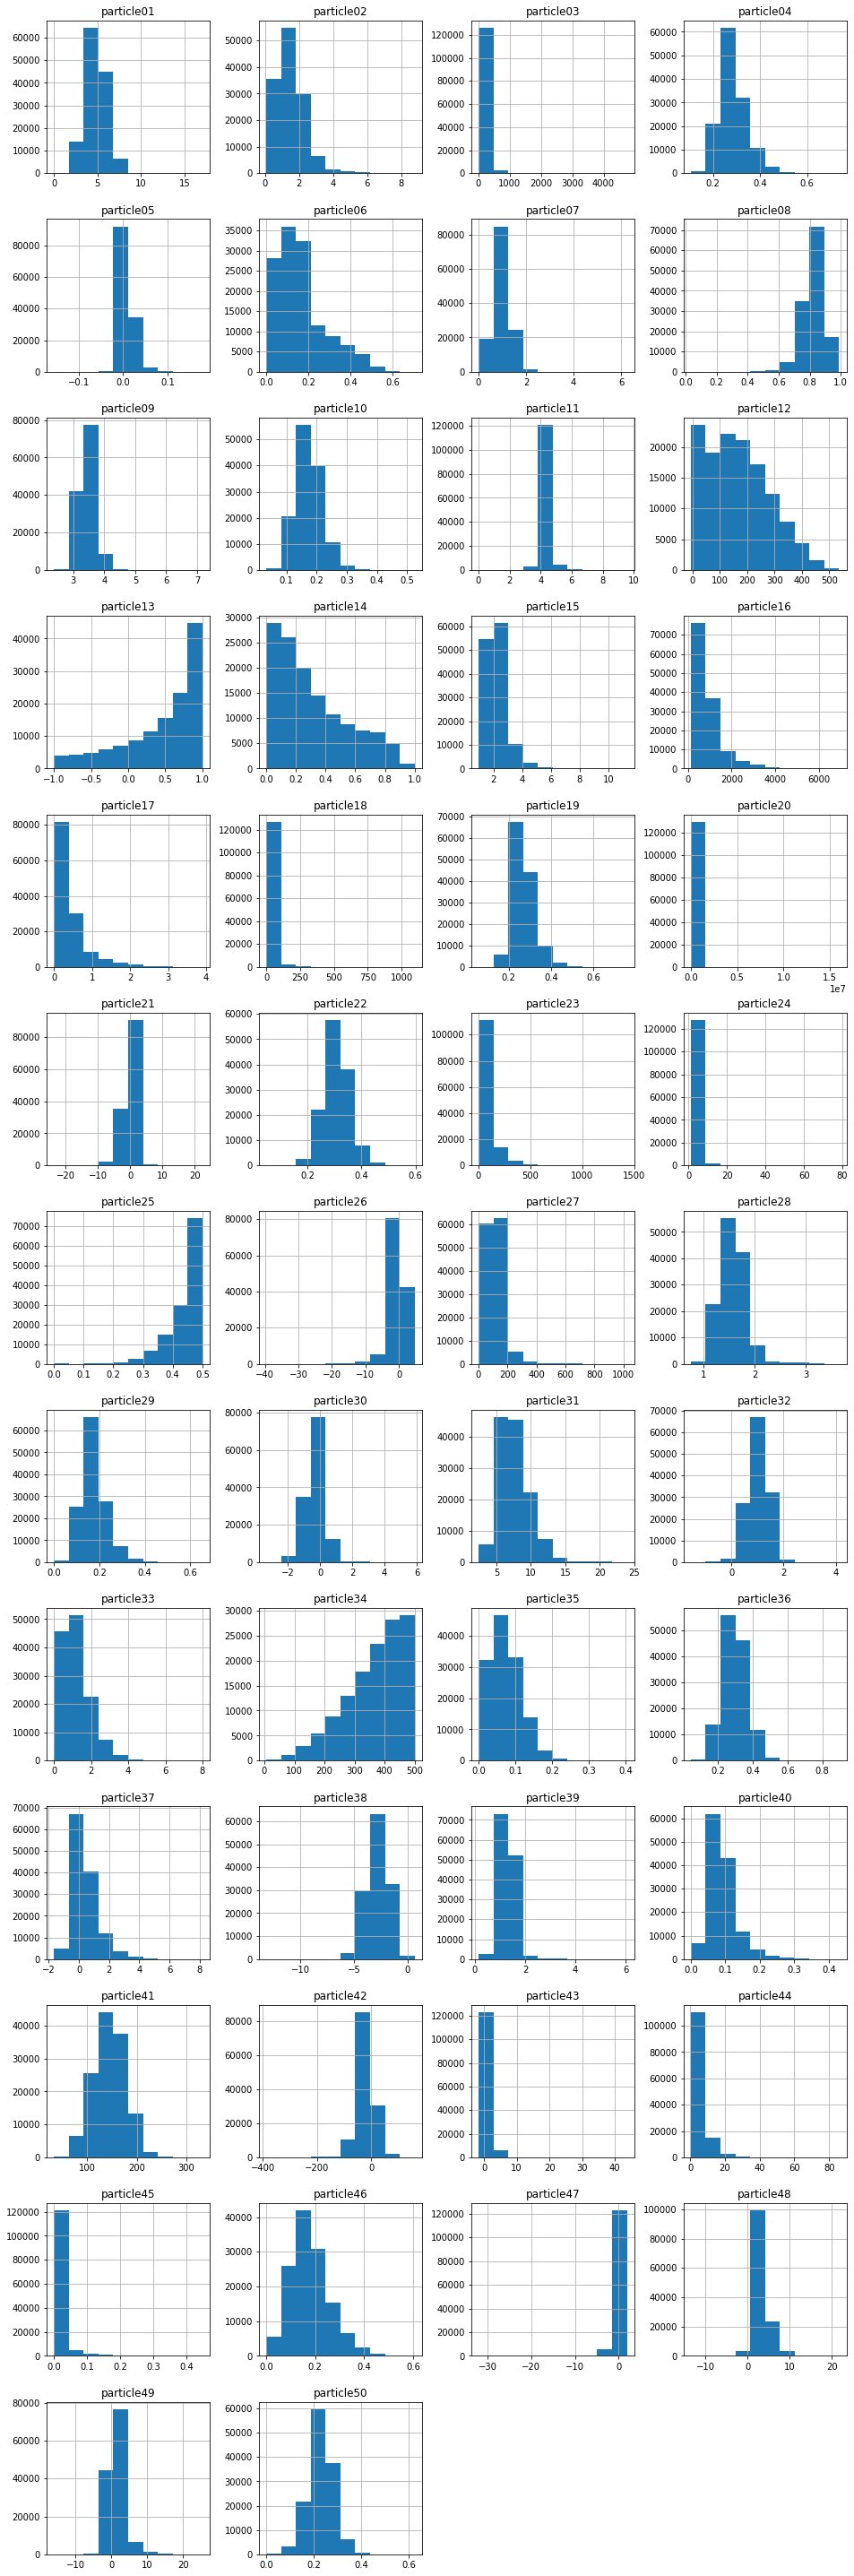

In [19]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [20]:
# Apply feature scaling and transformation
# X_original = X_original.astype(float)
# X_original['some_feature'] = preprocessing.scale(X_original['some_feature'])
preprocessing.scale(X_original, copy=False)
# X_original['some_feature'] = preprocessing.normalize(X_original['some_feature'])
# preprocessing.normalize(X_original, copy=False)
print(X_original.head(-10))

        particle01  particle02  particle03  particle04  particle05  \
0        -1.954580   -1.189547   -0.581235    0.663547    0.029684   
1        -0.861168   -0.983886   -0.595089   -0.832887    1.714776   
2        -1.272820   -0.343170   -0.497763   -1.381345    0.642781   
3        -0.498325   -1.141493    2.963457   -0.020284   -0.010946   
4         0.923718   -0.766333   -0.368676   -0.844238    1.261152   
...            ...         ...         ...         ...         ...   
130049    0.949879    0.807800    0.031532   -1.364016    0.525271   
130050    0.704829    0.930317   -0.209467    0.632029   -0.745331   
130051    0.376215   -0.591584    0.146414   -0.054807    0.055149   
130052    0.521143   -0.258374    0.218028    0.673655   -0.122389   
130053   -0.076460   -0.173426   -0.026679    0.336719   -0.745331   

        particle06  particle07  particle08  particle09  particle10  ...  \
0         1.737819   -0.486195    1.031514    0.561684    1.724753  ...   
1        

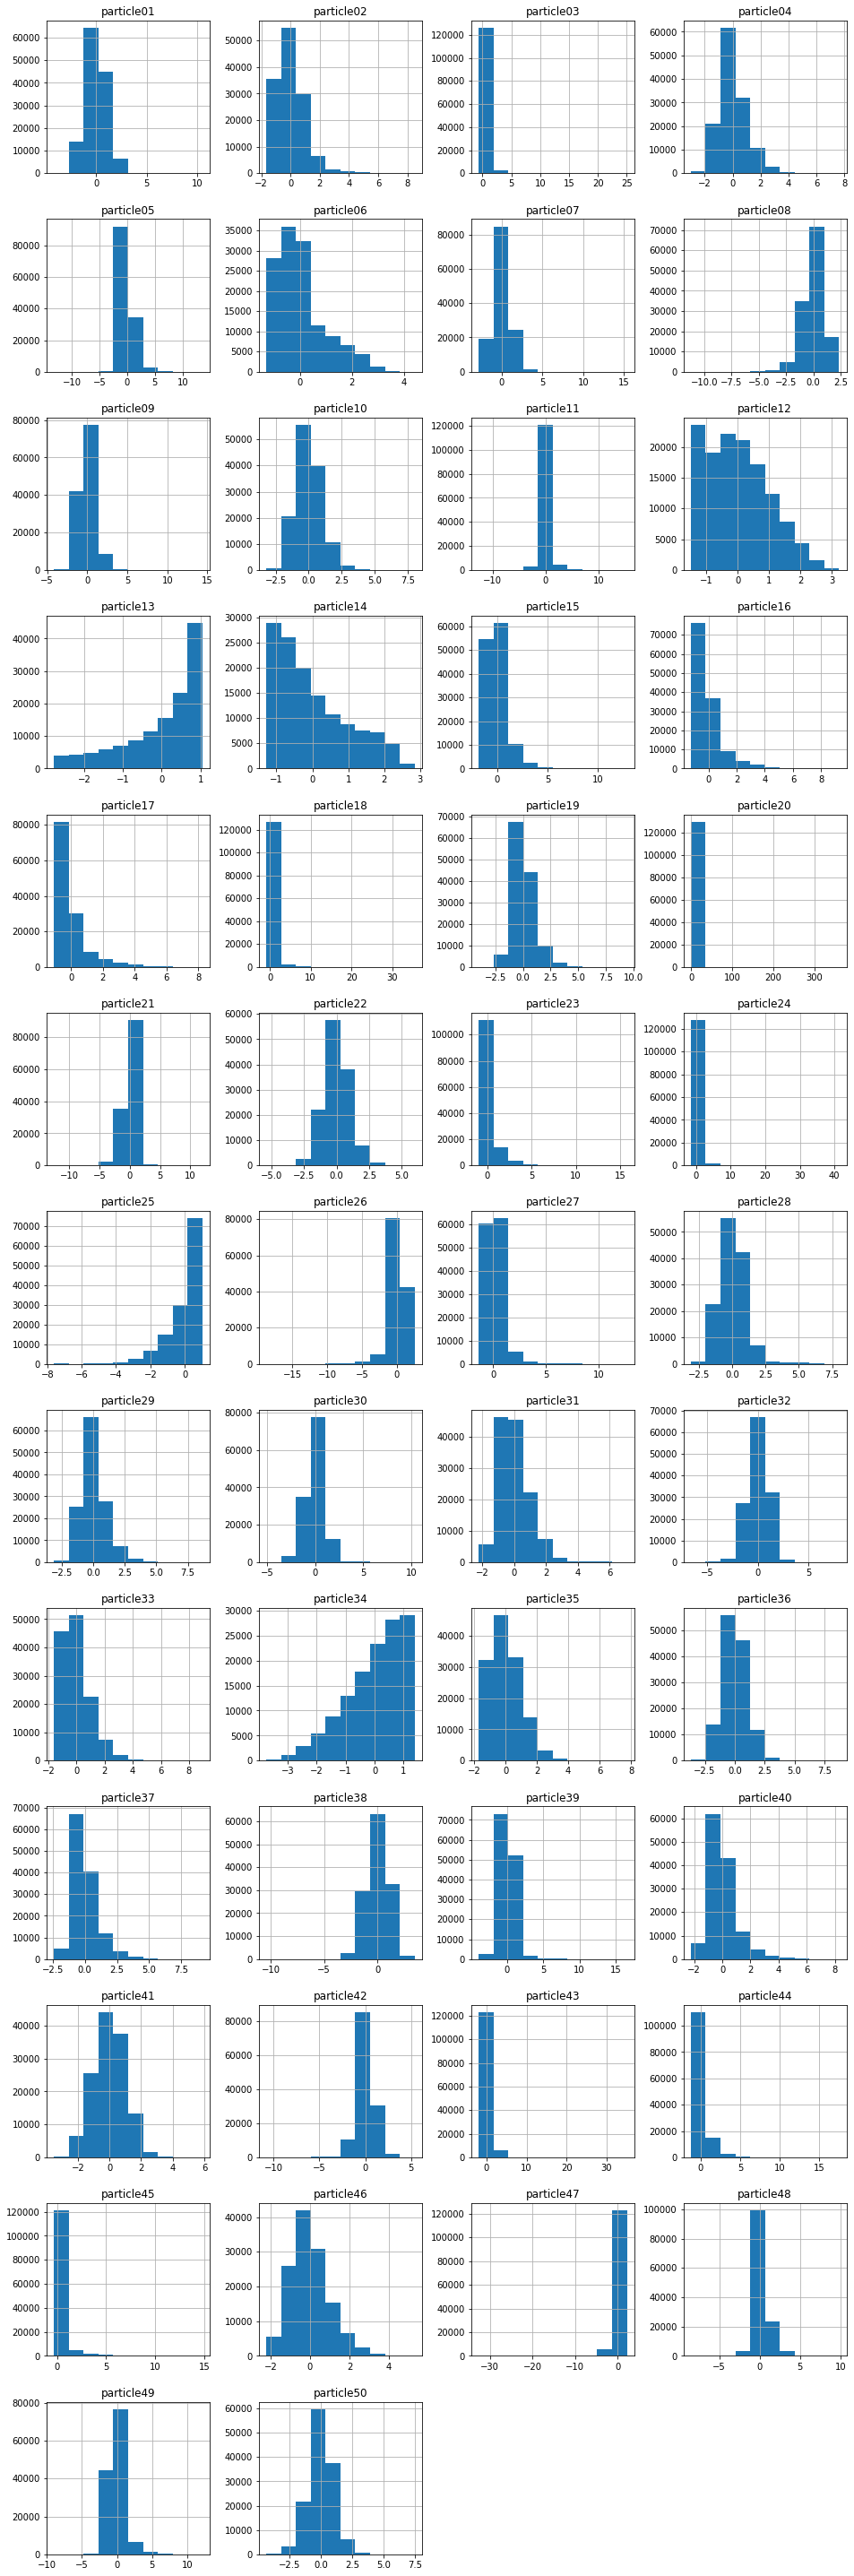

In [21]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

## 1.d) Splitting Data into Training and Test Sets

In [22]:
# Encode class values as integers and perform one-hot-encoding
# encoder = preprocessing.LabelEncoder()
# encoder.fit(y_original)
# y_encoded = encoder.transform(y_original)
# print(y_encoded)

In [23]:
# Split the data further into training and test datasets
X_encoded = X_original.to_numpy()
y_encoded = y_original.to_numpy()
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, 
                                                        stratify=y_encoded, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (97197, 50) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (97197,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (32399, 50) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (32399,) y_test.type: <class 'numpy.ndarray'>


In [24]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [25]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [26]:
# Define the Keras model required for KerasClassifier
def create_default_model():
    default_model = Sequential()
    default_model.add(Dense(50, input_shape=(50,), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(25, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, activation='sigmoid', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [27]:
# Initialize the Keras model
cv_model = KerasClassifier(build_fn=create_default_model, epochs=default_epochs, batch_size=default_batches, verbose=0)

In [28]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [29]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [30]:
startTimeModule = datetime.now()

# Fit and evaluate the Keras model using 10-fold cross validation
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
results = cross_val_score(cv_model, X_train, y_train, cv=kfold)
print('Generating results using the metrics of', default_metrics)
print('All cross-Validate results:', results)
print('Baseline results [mean (std)]: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job

In [31]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [32]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [33]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = Sequential()
    customized_model.add(Dense(50, input_shape=(50,), activation='relu', kernel_initializer=kernel_init))
    customized_model.add(Dense(25, activation='relu', kernel_initializer=kernel_init))
    customized_model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_init))
    customized_model.compile(loss=default_loss, optimizer=optimizer, metrics=default_metrics)
    return customized_model

In [34]:
startTimeModule = datetime.now()

# Create model
grid_model = KerasClassifier(build_fn=create_customized_model, verbose=0)

# Perform grid search using different epochs, batch sizes, and optimizers
optz_1 = K.optimizers.Adam(learning_rate=0.001)
optz_2 = K.optimizers.Adam(learning_rate=0.005)
optimizer_grid = [optz_1, optz_2]
init_1 = K.initializers.RandomNormal(seed=seedNum)
init_2 = K.initializers.Orthogonal(seed=seedNum)
init_grid = [init_1, init_2]
epoch_grid = [500, 1000]
batch_grid = [32, 64]
param_grid = dict(optimizer=optimizer_grid, kernel_init=init_grid, epochs=epoch_grid, batch_size=batch_grid)
# grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=n_folds, n_jobs=n_jobs, verbose=3)
n_iter = int(len(optimizer_grid) * len(init_grid) * len(epoch_grid) * len(batch_grid) * 0.5)
grid = RandomizedSearchCV(estimator=grid_model, param_distributions=param_grid, n_iter=n_iter, cv=n_folds, n_jobs=n_jobs, verbose=3)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 258.2min
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed: 456.1min remaining: 132.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 480.7min finished


Executing op __inference_keras_scratch_graph_30401908 in device /job:localhost/replica:0/task:0/device:CPU:0
Best: 0.937087 using {'optimizer': <keras.optimizers.Adam object at 0x7f634cdb5e50>, 'kernel_init': <keras.initializers.Orthogonal object at 0x7f634cdb5950>, 'epochs': 500, 'batch_size': 64}
0.933753 (0.001066) with: {'optimizer': <keras.optimizers.Adam object at 0x7f634cdb5a10>, 'kernel_init': <keras.initializers.Orthogonal object at 0x7f634cdb5950>, 'epochs': 1000, 'batch_size': 64}
0.932786 (0.001616) with: {'optimizer': <keras.optimizers.Adam object at 0x7f634cdb5e50>, 'kernel_init': <keras.initializers.Orthogonal object at 0x7f634cdb5950>, 'epochs': 1000, 'batch_size': 32}
0.935348 (0.002063) with: {'optimizer': <keras.optimizers.Adam object at 0x7f634cdb5a10>, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f634cdb55d0>, 'epochs': 1000, 'batch_size': 32}
0.935770 (0.001190) with: {'optimizer': <keras.optimizers.Adam object at 0x7f634cdb5a10>, 'kernel_init': <k

In [35]:
best_optimizer = grid_result.best_params_["optimizer"]
best_kernel_init = grid_result.best_params_["kernel_init"]
best_epoch = grid_result.best_params_["epochs"]
best_batch = grid_result.best_params_["batch_size"]

In [36]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [37]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [38]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
final_model = create_customized_model(best_optimizer, best_kernel_init)
final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, verbose=0)

Forming the final model using: optimizer=<keras.optimizers.Adam object at 0x7f634cdb5e50>, kernel=<keras.initializers.Orthogonal object at 0x7f634cdb5950>, epochs=500, batch_size=64
Executing op __inference_keras_scratch_graph_34201380 in device /job:localhost/replica:0/task:0/device:CPU:0


In [39]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_20 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 26        
Total params: 3,851
Trainable params: 3,851
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_7', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_19', 'trainable': True, 'batch_input_shape': (None, 50), 'dtype': 'float32', 'units': 50, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': 894}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_20', 'trainable': True, 'dtype': 'float32', 'units': 25, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': 894}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_21', 'trainab

In [41]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (final_model.metrics_names[1], scores[1]*100))
print("\n%s: %.2f" % (final_model.metrics_names[0], scores[0]))

Executing op __inference_keras_scratch_graph_37999944 in device /job:localhost/replica:0/task:0/device:CPU:0
32399/32399 [==============================] - 1s 35us/step

accuracy: 93.94%

loss: 0.20


In [42]:
# Make class predictions with the model
predictions = final_model.predict_classes(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %d (expected %d)' % (i, predictions[i], y_test[i]))

Executing op __inference_keras_scratch_graph_38005036 in device /job:localhost/replica:0/task:0/device:CPU:0
Data item #0 predicted to be 0 (expected 0)
Data item #1 predicted to be 0 (expected 0)
Data item #2 predicted to be 0 (expected 0)
Data item #3 predicted to be 0 (expected 0)
Data item #4 predicted to be 0 (expected 0)
Data item #5 predicted to be 0 (expected 0)
Data item #6 predicted to be 0 (expected 0)
Data item #7 predicted to be 1 (expected 1)
Data item #8 predicted to be 0 (expected 0)
Data item #9 predicted to be 0 (expected 0)
Data item #10 predicted to be 1 (expected 1)
Data item #11 predicted to be 0 (expected 0)
Data item #12 predicted to be 0 (expected 0)
Data item #13 predicted to be 1 (expected 1)
Data item #14 predicted to be 1 (expected 1)
Data item #15 predicted to be 0 (expected 0)
Data item #16 predicted to be 0 (expected 0)
Data item #17 predicted to be 0 (expected 0)
Data item #18 predicted to be 0 (expected 0)
Data item #19 predicted to be 0 (expected 0)


In [43]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [44]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 13:21:37.531703
